In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky/'

/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/LDS9_K273_BuiThiHuong_Cuoi_ky


In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF, Tokenizer
from pyspark.ml.feature import NGram

from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel, \
                                      LogisticRegression, LogisticRegressionModel, \
                                      RandomForestClassifier, RandomForestClassificationModel, \
                                      GBTClassifier, GBTClassificationModel
                                      
from pyspark.ml import Pipeline, PipelineModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import time

In [6]:
spark = SparkSession.builder.appName('nlp').getOrCreate()

## Read data

In [7]:
start_time = time.time()

In [8]:
# read fake data file
fake_data = spark.read.csv('Data/fake-and-real-news-dataset/Fake.csv', header=True, inferSchema=True)

In [9]:
fake_data.show(5)

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
+--------------------+--------------------+-------+-----------------+
only showing top 5 rows



In [10]:
fake_data.count()

23489

In [11]:
fake_data = fake_data.withColumn('label', lit(1).cast('float'))

In [12]:
# read real data file
real_data = spark.read.csv('Data/fake-and-real-news-dataset/True.csv', header=True, inferSchema=True)

In [13]:
real_data.show(5)

+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
+--------------------+--------------------+------------+------------------+
only showing top 5 rows



In [14]:
real_data.count()

21417

In [15]:
real_data = real_data.withColumn('label', lit(0).cast('float'))

In [16]:
# combine fake_data and real data
data = fake_data.unionAll(real_data)

In [17]:
data.show(5)

+--------------------+--------------------+-------+-----------------+-----+
|               title|                text|subject|             date|label|
+--------------------+--------------------+-------+-----------------+-----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|  1.0|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|  1.0|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|  1.0|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|  1.0|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|  1.0|
+--------------------+--------------------+-------+-----------------+-----+
only showing top 5 rows



In [18]:
data.count()

44906

In [19]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: float (nullable = false)



In [20]:
data.select('label').groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|23489|
|  0.0|21417|
+-----+-----+



* Data is not imbalance.

In [21]:
# check NaN
data.select([sum(when(isnan(col(col_name)),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
title,0
text,0
subject,0
date,0
label,0


In [22]:
# check null
data.select([sum(when(col(col_name).isNull(),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
title,0
text,8
subject,8
date,8
label,0


* There are null values => Have to remove rows have null values

In [23]:
data = data.na.drop()

In [24]:
# check null
data.select([sum(when(col(col_name).isNull(),1)
          .otherwise(0)).alias(col_name)
          for col_name in data.columns]).toPandas().T

,0
title,0
text,0
subject,0
date,0
label,0


In [25]:
# data = data.sample(0.01)

In [26]:
data.cache()

DataFrame[title: string, text: string, subject: string, date: string, label: float]

## Data Pre-processing

In [27]:
# create "title_text" column
data = data.select("*", concat(col("title"),lit(". "),col("text")).alias("title_text"))

In [28]:
data.show(4, False)

+------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
# create "length" column
data = data.withColumn('length', length(data['title_text']))

In [30]:
data.show(5)

+--------------------+--------------------+-------+-----------------+-----+--------------------+------+
|               title|                text|subject|             date|label|          title_text|length|
+--------------------+--------------------+-------+-----------------+-----+--------------------+------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|  1.0| Donald Trump Sen...|  2974|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|  1.0| Drunk Bragging T...|  1969|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|  1.0| Sheriff David Cl...|  3689|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|  1.0| Trump Is So Obse...|  2854|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|  1.0| Pope Francis Jus...|  2418|
+--------------------+--------------------+-------+-----------------+-----+--------------------+------+
only showing top 5 rows



In [31]:
data.select('length').agg({'length':'min'}).show()

+-----------+
|min(length)|
+-----------+
|         32|
+-----------+



class: 0.0


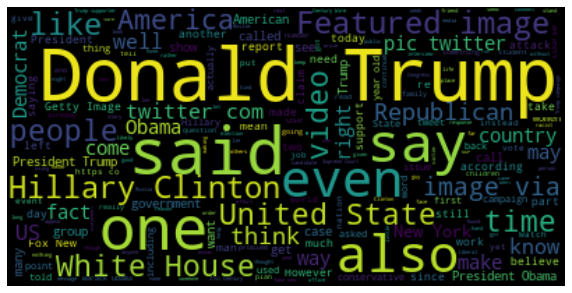

class: 1.0


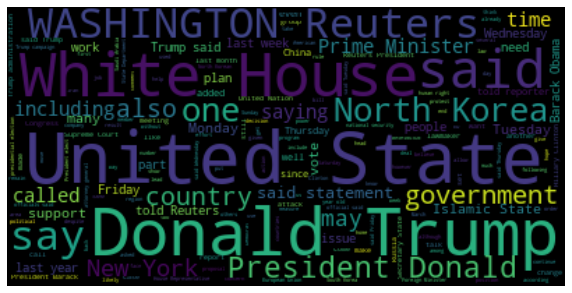

In [94]:
# # WordCloud chart of each class
# n = 0
# data_pdf = data.toPandas()
# y = data_pdf['label']
# X = data_pdf[['title_text']]
# stopwordList = StopWordsRemover().getStopWords()
# for i in y.sort_values().unique():
#     # Tạo text
#     text = ""
#     for j in X.iloc[y[y==y.unique()[n]].index].iloc[:,0]:
#         text = text + " " + j
#     # Bieu do WordCloud
#     plt.figure(figsize=(10,10))
#     wc_text=WordCloud(stopwords = stopwordList)
#     wc_text.generate(text)
#     print('class:',i)
#     plt.imshow(wc_text,interpolation="bilinear")
#     plt.axis("off")
#     plt.show()
#     n=n+1

In [33]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- label: float (nullable = false)
 |-- title_text: string (nullable = true)
 |-- length: integer (nullable = true)



### TEST

#### Tokenizer (test)

In [34]:
# tokenizer = Tokenizer(inputCol='text', outputCol='words')

# regexTokenizer = RegexTokenizer(inputCol='text', outputCol='words', pattern='\\W')
# # alternatively, pattern="\\W", gaps(False)

# countTokens = udf(lambda words: len(words), IntegerType())

In [35]:
# tokenized = tokenizer.transform(train_data)

# tokenized.select('title_text','words')\
#                   .withColumn('tokens', countTokens(col('words'))).show(5, truncate=False)

In [36]:
# regexTokenized = regexTokenizer.transform(train_data)

# r = regexTokenized.withColumn('tokens', countTokens(col('words')))

In [37]:
# r.show()

#### StopwordsRemover (test)

In [38]:
# remover = StopWordsRemover(inputCol='words', outputCol='filtered')
# r = remover.transform(r)
# r.show(5, truncate=False)

In [39]:
# r.show(5)

#### NGram (test)

In [40]:
# ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

# ngramDataFrame = ngram.transform(r)
# ngramDataFrame.select('class','text','ngrams').show(truncate=False)

#### CountVectorizer (test)

In [41]:
# r.printSchema()

In [42]:
# r.select('tokens').agg({'tokens':'min'}).show()

In [43]:
# # fit a CountVectorizerModel from the corpus
# # cv = CountVectorizer(inputCol='filtered', outputCol='features', vocabSize=500, minDF=1)
# cv = CountVectorizer(inputCol='words', outputCol='features')
# model = cv.fit(r)
# result = model.transform(r)
# result.show(5)

#### TF-IDF (test)

In [44]:
# idf = IDF(inputCol='features', outputCol='tf_idf_features')
# idfModel = idf.fit(result)
# rescaledData = idfModel.transform(result)
# rescaledData.select('features', 'tf_idf_features').show(truncate=False)

#### StringIndexer (test)

In [45]:
# indexer = StringIndexer(inputCol='class',
#                         outputCol='label')

In [46]:
# indexed = indexer.fit(rescaledData)
# clean_data = indexed.transform(rescaledData)

In [47]:
# clean_data.select('label','tf_idf_features').show()

#### Train, Test Splitting (test)

In [48]:
# train_data, test_data = clean_data.randomSplit([0.7,0.3])

In [49]:
# train_data.count()

In [50]:
# test_data.count()

#### Build model (test)

In [51]:
# train_data.columns

In [52]:
# nb = NaiveBayes(featuresCol='tf_idf_features',
#                       labelCol='label')

In [53]:
# nb_model = nb.fit(train_data)

In [54]:
# test_predictions = nb_model.transform(test_data)

In [55]:
# test_predictions.show(5)

## Train, Test Splitting

In [56]:
train_data, test_data = data.randomSplit([0.7,0.3])

In [57]:
train_data.count()

31529

In [58]:
test_data.count()

13369

In [59]:
train_data.columns

['title', 'text', 'subject', 'date', 'label', 'title_text', 'length']

## Pipeline

In [60]:
# tokenizer
regexTokenizer = RegexTokenizer(inputCol='title_text', outputCol='words', pattern='\\W')

# # NGram
# ngram = NGram(n=2, inputCol='words', outputCol='ngrams')

# stopwords
# remover = StopWordsRemover(inputCol='ngrams', outputCol='filtered')
# stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
remover = StopWordsRemover(inputCol='words', outputCol='filtered')

# CountVectorizer
cv = CountVectorizer(inputCol='filtered', outputCol='features', vocabSize=500, minDF=1)

# TF-IDF
idf = IDF(inputCol='features', outputCol='tf_idf_features')

# VectorAssembler
assembler = VectorAssembler(inputCols=['tf_idf_features','length'],
                            outputCol='vec_features')

# # StringIndexer
# indexer = StringIndexer(inputCol='class',
#                         outputCol='label')

In [61]:
# NaiveBayes
nb = NaiveBayes(featuresCol='vec_features',
                      labelCol='label')
# LogisticRegression
lg = LogisticRegression(featuresCol='vec_features',
                        labelCol='label',
                        maxIter=20,
                        regParam=0.3,
                        elasticNetParam=0)
# RandomForest
rf = RandomForestClassifier(featuresCol='vec_features',
                            labelCol='label',
                            numTrees=500,
                            maxDepth=5,
                            maxBins=64
                            )
# Gradient_Boosted Tree Classifier
gbt = GBTClassifier(featuresCol='vec_features',
                    labelCol='label',
                    maxDepth=5,
                    maxBins=64)

In [62]:
# create pipelines
pipeline_nb = Pipeline(stages=[regexTokenizer,
                                  remover,                                  
                                  cv,
                                  idf,
                                  assembler,
                                  nb])
pipeline_lg = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  lg])
pipeline_rf = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  rf])
pipeline_gbt = Pipeline(stages=[regexTokenizer,
                                  remover,
                                  cv,
                                  idf,
                                  assembler,
                                  gbt])

## Build model

In [63]:
# train pipeline model with train_data
pipeline_nb_model = pipeline_nb.fit(train_data)
pipeline_lg_model = pipeline_lg.fit(train_data)
pipeline_rf_model = pipeline_rf.fit(train_data)
pipeline_gbt_model = pipeline_gbt.fit(train_data)

## Evaluation

In [64]:
# predict with test data and built models
test_predictions_nb = pipeline_nb_model.transform(test_data)
test_predictions_lg = pipeline_lg_model.transform(test_data)
test_predictions_rf = pipeline_rf_model.transform(test_data)
test_predictions_gbt = pipeline_gbt_model.transform(test_data)

In [65]:
# create function for classification evaluation
def classification_evaluation(model,test_data,labelCol,predictionCol,):
  import pyspark
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
  from pyspark.mllib.evaluation import  MulticlassMetrics
  predictions_data = model.transform(test_data)
  # predictions_data.groupBy(labelCol, predictionCol).count().orderBy(predictionCol)
  preds_and_labels = predictions_data.select([predictionCol,labelCol]).withColumn(labelCol,col(labelCol).cast('float')).orderBy(predictionCol)
  preds_and_labels = preds_and_labels.select([predictionCol,labelCol])
  
  # AUC on testing data
  acc = MulticlassClassificationEvaluator(labelCol=labelCol,
                                            predictionCol=predictionCol,
                                            metricName='accuracy')
  
  acc = acc.evaluate(preds_and_labels)
  acc
  # AUC on testing data
  evaluator = BinaryClassificationEvaluator(labelCol=labelCol)
  auc = evaluator.evaluate(predictions_data)
  # confusion matrix
  matrix = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  matrix = pd.DataFrame(matrix.confusionMatrix().toArray())
  return acc, auc, matrix

In [66]:
# evaluate built models one by one
lst_models = [pipeline_nb_model, pipeline_lg_model, pipeline_rf_model, pipeline_gbt_model]
lst_acc=['acc']
lst_auc=['auc']
for i in lst_models:
  acc, auc, matrix = classification_evaluation(i, test_data, labelCol='label', predictionCol='prediction')
  lst_acc.append(acc)
  lst_auc.append(auc)

In [67]:
# list of accuracy metrics
lst_acc

['acc',
 0.9274440870670955,
 0.9768120278255666,
 0.9939412072705512,
 0.9957364051163139]

In [68]:
# list of AUC metrics
lst_auc

['auc',
 0.5249356482678852,
 0.9943255767488953,
 0.999593360151534,
 0.9992395866248563]

In [69]:
# show the evaluation results
col_names = ['Metric name','NaiveBayes','LogisticRegression','RandomForest','Gradient-Boosted Trees']
summary = [lst_acc, lst_auc]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df = spark.createDataFrame(summary, col_names)
summary_df.show()

+-----------+------------------+------------------+------------------+----------------------+
|Metric name|        NaiveBayes|LogisticRegression|      RandomForest|Gradient-Boosted Trees|
+-----------+------------------+------------------+------------------+----------------------+
|        acc|0.9274440870670955|0.9768120278255666|0.9939412072705512|    0.9957364051163139|
|        auc|0.5249356482678852|0.9943255767488953| 0.999593360151534|    0.9992395866248563|
+-----------+------------------+------------------+------------------+----------------------+



In [70]:
# create a function for to show confusion matrix
def confusion_matrix (model, test_data, labelCol, predictionCol):
  from pyspark.mllib.evaluation import  MulticlassMetrics
  # predictions_dtc.groupBy('label_idx', 'prediction').count().orderBy('prediction').show()
  predictions_data = model.transform(test_data)
  preds_and_labels = predictions_data.select([predictionCol,labelCol]).withColumn(labelCol, col(labelCol).cast('float')).orderBy(predictionCol)
  preds_and_labels = preds_and_labels.select([predictionCol,labelCol])

  # confusion matrix
  confusion_matrix = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  # dtc_matrix.confusionMatrix().toArray()
  confusion_matrix = pd.DataFrame(confusion_matrix.confusionMatrix().toArray())
  return confusion_matrix

In [71]:
# show confusion matrix of models, one by one
j=0
for i in lst_models:
  matrix = confusion_matrix(i, test_data, labelCol='label', predictionCol='prediction')
  print(col_names[j+1])
  print(matrix)
  j+=1

NaiveBayes
        0       1
0  5843.0   499.0
1   471.0  6556.0
LogisticRegression
        0       1
0  6228.0   114.0
1   196.0  6831.0
RandomForest
        0       1
0  6332.0    10.0
1    71.0  6956.0
Gradient-Boosted Trees
        0       1
0  6328.0    14.0
1    43.0  6984.0


* According to acc and auc metrics. Gradient-Boosted Tree Model and RandomForest Model are the best models. LogisticRegression Model is the second. 
* But the four models are good enough to use. So we can save both four models.

## Cross Validation

In [76]:
# cross validation
lst_pipelines = [pipeline_nb, pipeline_lg, pipeline_rf, pipeline_gbt]
lst_acc_means=['acc_cv']
lst_auc_means=['auc_cv']
k=1
for i in lst_pipelines:
  lst_acc=[]
  lst_auc=[]
  for n in range(1,6):
    train_data, test_data = data.randomSplit([0.7,0.3])
    model = i.fit(train_data)
    acc, auc, matrix = classification_evaluation(model, test_data, labelCol='label', predictionCol='prediction')
    lst_acc.append(acc)
    lst_auc.append(auc)
  print(col_names[k])
  print(lst_acc)
  print(lst_auc)
  k+=1
  lst_acc_means.append(float(np.mean(lst_acc)))
  lst_auc_means.append(float(np.mean(lst_auc)))

NaiveBayes
[0.9238469523950764, 0.9264187003822405, 0.9266061813085491, 0.924953095684803, 0.9279139974965025]
[0.5289810421172537, 0.5317403666350884, 0.5229613523653418, 0.528010885793303, 0.5313087487815076]
LogisticRegression
[0.9802249503785929, 0.9764688249400479, 0.9775181186215057, 0.977274404190954, 0.9768501506577497]
[0.9951332401542832, 0.9940592988491871, 0.9938808174462548, 0.9942280192867086, 0.9943443559162197]
RandomForest
[0.9923156494753953, 0.9930168635316842, 0.9942009338755837, 0.9921050689884159, 0.9939897603324181]
[0.999357418608472, 0.9995233770222118, 0.9994755952408554, 0.9991394339126127, 0.9992411583057047]
Gradient-Boosted Trees
[0.9956963715960525, 0.9963625566030733, 0.9950797674071865, 0.9966691339748335, 0.9958174620957503]
[0.9990810335641489, 0.9990228754259695, 0.999140136732228, 0.9991354438830102, 0.9991656362776202]


In [77]:
# type(np.mean(lst_acc_cv))

In [78]:
# type(float(np.mean(lst_acc_cv)))

In [79]:
# type(acc)

In [80]:
# show the evaluation results
col_names = ['Metric name','NaiveBayes','LogisticRegression','RandomForest','Gradient-Boosted Trees']
summary_cv = [lst_acc_means, lst_auc_means]

# summary_df = pd.DataFrame.from_dict(dict(zip(col_names, metric_names)))
summary_df_cv = spark.createDataFrame(summary_cv, col_names)
summary_df_cv.show()

+-----------+------------------+------------------+------------------+----------------------+
|Metric name|        NaiveBayes|LogisticRegression|      RandomForest|Gradient-Boosted Trees|
+-----------+------------------+------------------+------------------+----------------------+
|     acc_cv|0.9259477854534343|0.9776672897577701|0.9931256552406994|    0.9959250583353793|
|     auc_cv|0.5286004791384988|0.9943291463305307|0.9993473966179713|    0.9991090251765954|
+-----------+------------------+------------------+------------------+----------------------+



* According to cross validation results, estimator performances of each models are good.

## Save model

In [81]:
# save models
pipeline_nb_model.write().overwrite().save('C1_Classification_pipeline_nb_FakeRealNews')
pipeline_lg_model.write().overwrite().save('C1_Classification_pipeline_lg_FakeRealNews')
pipeline_rf_model.write().overwrite().save('C1_Classification_pipeline_rf_FakeRealNews')
pipeline_gbt_model.write().overwrite().save('C1_Classification_pipeline_gbt_FakeRealNews')

In [82]:
# load models from parquets
pipeline_nb_model_1 = PipelineModel.load('C1_Classification_pipeline_nb_FakeRealNews')
pipeline_lg_model_1 = PipelineModel.load('C1_Classification_pipeline_lg_FakeRealNews')
pipeline_rf_model_1 = PipelineModel.load('C1_Classification_pipeline_rf_FakeRealNews')
pipeline_gbt_model_1 = PipelineModel.load('C1_Classification_pipeline_gbt_FakeRealNews')

In [83]:
# predict new values (Assuming select test_data)
unlabeled_data = test_data

In [84]:
unlabeled_data.count()

13389

In [85]:
test_predictions_nb_1 = pipeline_nb_model_1.transform(unlabeled_data)
test_predictions_lg_1 = pipeline_lg_model_1.transform(unlabeled_data)
test_predictions_rf_1 = pipeline_rf_model_1.transform(unlabeled_data)
test_predictions_gbt_1 = pipeline_gbt_model_1.transform(unlabeled_data)

In [86]:
test_predictions_nb_1.select('title_text','label','prediction').show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [87]:
test_predictions_lg_1.select('title_text','label','prediction').show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [88]:
test_predictions_rf_1.select('title_text','label','prediction').show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [89]:
test_predictions_gbt_1.select('title_text','label','prediction').show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [90]:
data.unpersist()

DataFrame[title: string, text: string, subject: string, date: string, label: float, title_text: string, length: int]

In [95]:
end_time = time.time()

In [96]:
duration = (end_time - start_time)/60
duration = int(duration)

In [97]:
print('Total time for model training is about', duration, 'minutes')

Total time for model training is about 72 minutes
